## Setup

In [147]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get and print current working directory
cwd = os.path.dirname(os.getcwd())
print("Current working directory:", cwd)

# Define output path
output_dir = os.path.join(cwd, "data", "aoi")
dir_figure = os.path.join(cwd, "figures")


Current working directory: d:\natcap\invest-mental-health


In [148]:

# Load shapefiles
dir_shp = 'D:/data/shp/US_census_Cartographic_Boundary_Shapefiles' 

dir_place     = os.path.join(dir_shp, 'UAC/cb_2020_us_place_500k/cb_2020_us_place_500k.shp')
dir_place_cdc = 'D:/natcap/PLACES/raw/500Cities_City_11082016/CityBoundaries.shp'

dir_state     = os.path.join(dir_shp, "cb_2020_us_state_500k/cb_2020_us_state_500k.shp")



## Places within Metro

original place_data: 
     (32188, 22)

filterred place_data (n >= 50,000, density >= 1500 per km2):
    (491, 22)


Cities, which have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2) 
-- based on `Degree of Urbanization` by World Bank [https://blogs.worldbank.org/en/sustainablecities/how-do-we-define-cities-towns-and-rural-areas]

```
        
        pop >= 50k         pop_d >= 1k/km2           ensure 1 each state        city-code         in metro          ensure 1 each state      in mainland 
32,188 -------------> 796 --------------------> 491 --------------------> 502 --------------> 500 ------------> 487 --------------------> 488 -----------> 487


                           pop_d >= 1.5k/km2
32,188 -------------> 796 --------------------> 288 --------------------> ??? --------------> 276 ------------> 271

```

In [149]:
import geopandas as gpd

# # Load shapefiles

# Filter Place LSAD (city or town)
#   https://www2.census.gov/geo/pdfs/reference/LSADCodes.pdf
place_lsad_keep = ["00", "25", "CG", "MG", "MT", "UG",
                   "37", "43", "47", "53", "BL", "CB", "CN", "MB", "UB", "UC"]

met_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_metro_combined_metdiv_no_overlap.shp"))
## to prevent issues with data type limitation in the ESRI Shapefile format later
print(met_layer.columns)
# met_layer["ALAND_METR"] = met_layer["ALAND_METR"].astype(float)
# met_layer["AWATER_MET"] = met_layer["AWATER_MET"].astype(float)
met_layer = met_layer.drop(columns=['ALAND_METR', 'AWATER_MET'])



# pla_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_place_with_population_filtered_1500_288.shp") ) # filtered by population density >= 1,500 people/km²
# pla_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_place_with_population_filtered_1000_491.shp") ) # filtered by population density >= 1,000 people/km²
pla_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_place_with_population_filtered_1000_502.shp") ) # filtered by population density >= 1,000 people/km² + ensure 1 each state

place_layer = pla_layer[pla_layer['LSAD'].isin(place_lsad_keep)] ## 502 -> 500
# place_layer = pla_layer

# print(met_layer)
# print(pla_layer)
# test_statefps = set(place_layer['STATEFP'].unique())
# print(test_statefps)

print('pla_layer: \n\t', pla_layer.shape)
print('place_layer (filter cities): \n\t', place_layer.shape)
# print(met_layer.shape)

print(met_layer.columns)
print(place_layer.columns)

Index(['CSAFP', 'CBSAFP', 'METDIVFP', 'AFFGEOID', 'GEOID_METR', 'NAME_METRO',
       'NAMELSAD', 'LSAD_x', 'ALAND_METR', 'AWATER_MET', 'MDIV', 'LSAD_y',
       'SBASE2020', 'POP2020', 'POP2021', 'POP2022', 'POP2023', 'POP2024',
       'GEOID_MDIV', 'POP_KM2', 'count', 'level', 'geometry'],
      dtype='object')
pla_layer: 
	 (502, 22)
place_layer (filter cities): 
	 (500, 22)
Index(['CSAFP', 'CBSAFP', 'METDIVFP', 'AFFGEOID', 'GEOID_METR', 'NAME_METRO',
       'NAMELSAD', 'LSAD_x', 'MDIV', 'LSAD_y', 'SBASE2020', 'POP2020',
       'POP2021', 'POP2022', 'POP2023', 'POP2024', 'GEOID_MDIV', 'POP_KM2',
       'count', 'level', 'geometry'],
      dtype='object')
Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID', 'GEOID_PLAC', 'NAME_PLACE',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER', 'SUMLEV',
       'STATE', 'PLACE', 'POP2020', 'POP2021', 'POP2022', 'POP2023', 'POP2024',
       'POP_KM2', 'geometry'],
      dtype='object')


### filter places that within_or_overlap with Metro

In [150]:
# Example: assuming original CRS is EPSG:4269 (common for US Census shapefiles)
if place_layer.crs is None:
    place_layer = place_layer.set_crs("EPSG:4269")  # Replace with correct CRS if needed



In [151]:

# Ensure both GeoDataFrames use the same CRS
if met_layer.crs != place_layer.crs:
    print("Reprojecting place_layer to match met_layer CRS...")
    place_layer = place_layer.to_crs(met_layer.crs)

    
# Filter places: retain only those that intersect with metropolitan areas
# Spatial join: keep full Place polygons that intersect with any Metro
places_in_met = gpd.sjoin(
    place_layer, met_layer, 
    how='inner',             # Only keep matching Places
    predicate='intersects'   # Places that touch or overlap Metro
).drop(columns="index_right")

print(places_in_met.columns)

print(f"Places retained: {len(places_in_met)}")
print('places_in_met (filter by Metro): \n\t', places_in_met.shape)



# 📌 You might noticed the filter data geberate more `Places`, this is because
#   If a single Place overlaps multiple Metropolitan areas, then gpd.sjoin(..., how='inner') 
#   will duplicate that Place once for each Metro it intersects.
# For example:
# A Place overlaps 2 Metros → appears twice in the join result.
# A Place overlaps 3 Metros → appears 3 times.
# And so on.
# --> to fix it and get distinct places, we need to drop duplicates after the spatial join

places_in_met_unique = places_in_met.drop_duplicates(['GEOID_PLAC', 'NAME_PLACE'], keep='first')

print('places_in_met_unique (filter by Metro): \n\t', places_in_met_unique.shape)



Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID_left', 'GEOID_PLAC',
       'NAME_PLACE', 'NAMELSAD_left', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'SUMLEV', 'STATE', 'PLACE', 'POP2020_left', 'POP2021_left',
       'POP2022_left', 'POP2023_left', 'POP2024_left', 'POP_KM2_left',
       'geometry', 'CSAFP', 'CBSAFP', 'METDIVFP', 'AFFGEOID_right',
       'GEOID_METR', 'NAME_METRO', 'NAMELSAD_right', 'LSAD_x', 'MDIV',
       'LSAD_y', 'SBASE2020', 'POP2020_right', 'POP2021_right',
       'POP2022_right', 'POP2023_right', 'POP2024_right', 'GEOID_MDIV',
       'POP_KM2_right', 'count', 'level'],
      dtype='object')
Places retained: 581
places_in_met (filter by Metro): 
	 (581, 42)
places_in_met_unique (filter by Metro): 
	 (487, 42)


### ensure 1 place in each state

In [152]:
# 1. Get full list of mainland STATEFPs from the original state layer
all_statefps = set(pla_layer['STATEFP'].unique())

# 2. Get STATEFPs that are present in the spatially joined result
included_statefps = set(places_in_met_unique['STATEFP'].unique())

# 3. Find missing states
missing_statefps = sorted(all_statefps - included_statefps)
print(f"🟡 States missing from filtered places: {missing_statefps}")

# 4. For each missing state, pick the most populous place from that state
additional_places = []
for statefp in missing_statefps:
    state_places = place_layer[place_layer['STATEFP'] == statefp]
    if not state_places.empty:
        # Pick the one with the highest population (or largest area if pop not available)
        if 'POP2020' in state_places.columns:
            top_place = state_places.sort_values('POP2020', ascending=False).iloc[0]
        else:
            top_place = state_places.iloc[0]
        additional_places.append(top_place)

# 5. Combine the missing ones back with the filtered places
if additional_places:
    additional_df = gpd.GeoDataFrame(additional_places, crs=place_layer.crs)
    places_in_met_fixed = pd.concat([places_in_met_unique, additional_df], ignore_index=True)
    places_in_met_fixed = places_in_met_fixed.drop_duplicates(subset='GEOID_PLAC')  # Replace 'GEOID' if needed
else:
    places_in_met_fixed = places_in_met.copy()

# Final check
print(f"✅ Final number of places (after fixing): {len(places_in_met_fixed)}")
print(f"✅ States now represented: {places_in_met_fixed['STATEFP'].nunique()} / {len(all_statefps)}")


🟡 States missing from filtered places: ['13', '15']
✅ Final number of places (after fixing): 488
✅ States now represented: 50 / 51


### filter by mainland US only

In [153]:
# STATEFP codes to exclude: AK, HI, PR, GU, VI, AS, MP, etc.
excluded_statefp = ['02', '15', '60', '66', '69', '72', '78'] 
excluded_statefp_w_dc = excluded_statefp + ['11']  # '11' is DC
excluded_state_abbr = ['AK', 'HI', 'PR', 'GU', 'VI', 'AS', 'MP']


# Add derived STATEFP column from GEOID_METR
# met_layer['STATEFP'] = met_layer['GEOID_METR'].str[:2]
# Extract state abbreviation (e.g., "CA") from NAME_METRO
met_layer['STATE_ABBR'] = met_layer['NAME_METRO'].str.extract(r',\s*([A-Z]{2})$')


# print(met_layer.head())

places_in_met_unique_mainland = places_in_met_fixed[~places_in_met_fixed['STATEFP'].isin(excluded_statefp)]


## 2. metropolitan layer -------
# met_layer_mainland = met_layer[~met_layer['STATEFP'].isin(excluded_statefp)]
met_layer_mainland = met_layer[~met_layer['STATE_ABBR'].isin(excluded_state_abbr)]


## 3. state layer -------
# Load state boundaries (make sure you have this file)
state_layer = gpd.read_file(dir_state)

# Exclude non-mainland states
state_layer_mainland = state_layer[~state_layer['STATEFP'].isin(excluded_statefp_w_dc)] 


## 4. Check for missing states 
# 1. Get all state codes from the original state layer
all_statefps = set(state_layer_mainland['STATEFP'].unique())

# 2. Get the state codes present in the filtered places
included_statefps = set(places_in_met_unique_mainland['STATEFP'].unique())

# 3. Find missing states
missing_statefps = sorted(all_statefps - included_statefps)

print(f"🟡 States with no included places: {missing_statefps}")
print(f"✅ Total states represented: {len(included_statefps)} / {len(all_statefps)}")
print(f"✅ Total Places in mainland: {len(places_in_met_unique_mainland)}")


🟡 States with no included places: []
✅ Total states represented: 49 / 48
✅ Total Places in mainland: 487


### save data

In [154]:
n_places = len(places_in_met_unique_mainland)

# save filtered places
f = os.path.join(cwd, "data", "aoi", f"places_in_or_touching_metros_{n_places}.shp")
print(f"Saving filtered places to: \n{f}")
places_in_met_unique_mainland.to_file(f)



Saving filtered places to: 
d:\natcap\invest-mental-health\data\aoi\places_in_or_touching_metros_487.shp


C:\Users\pc\AppData\Local\Temp\ipykernel_19892\2497801125.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  places_in_met_unique_mainland.to_file(f)
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'AFFGEOID_left' to 'AFFGEOID_l'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NAMELSAD_left' to 'NAMELSAD_l'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POP2020_left' to 'POP2020_le'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POP2021_left' to 'POP2021_le'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\sit

### plot

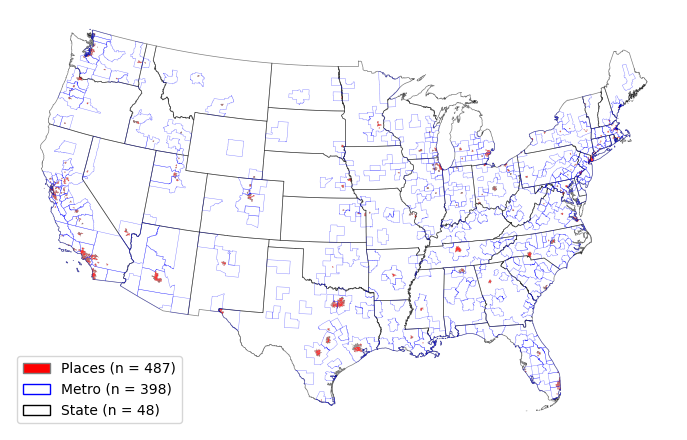

✅ Plot saved to: d:\natcap\invest-mental-health\figures\places_within_metros_487.png


In [155]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import os

# Set working directory or output path
f = f"places_within_metros_{n_places}.png"
output_path = os.path.join(dir_figure, f)

# Load your data (if not already loaded)
# place_layer = gpd.read_file("path/to/place.shp")
# met_layer = gpd.read_file("path/to/metro.shp")
# places_in_met_unique = ...




# 🌍 Reproject all layers to Albers Equal Area (EPSG:5070) for accurate area representation
target_crs = "EPSG:5070"
places_in_met_unique_mainland = places_in_met_unique_mainland.to_crs(target_crs)
met_layer_mainland = met_layer_mainland.to_crs(target_crs)
state_layer_mainland = state_layer_mainland.to_crs(target_crs)


## Plot -------------------------------------------------------------------------------

# # Ensure consistent CRS for plotting
# if places_in_met_unique_mainland.crs != met_layer_mainland.crs:
#     met_layer_mainland = met_layer_mainland.to_crs(places_in_met_unique_mainland.crs)

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4.5))


# Plot state boundaries (black)
state_layer_mainland.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)

# Plot metro boundaries
met_layer_mainland.boundary.plot(ax=ax, color='blue', linewidth=.3, alpha=0.5)

# Plot places
places_in_met_unique_mainland.plot(ax=ax, color='red', edgecolor='gray', linewidth=0.1, alpha=0.8)


# Custom legend
legend_elements = [
    Patch(facecolor='red', edgecolor='gray', label=f'Places (n = {len(places_in_met_unique_mainland)})'),
    Patch(facecolor='none', edgecolor='blue', label=f'Metro (n = {len(met_layer_mainland)})'),
    Patch(facecolor='none', edgecolor='black', label=f'State (n = {len(state_layer_mainland)})')
]
ax.legend(handles=legend_elements, loc='lower left')

# Title and formatting
# ax.set_title("Places Within or Overlapping Metropolitan Areas", fontsize=14)
ax.axis("off")

# Save as PNG
plt.tight_layout()
plt.savefig(output_path, dpi=600)
plt.show()

print(f"✅ Plot saved to: {output_path}")


### plot - blk bg


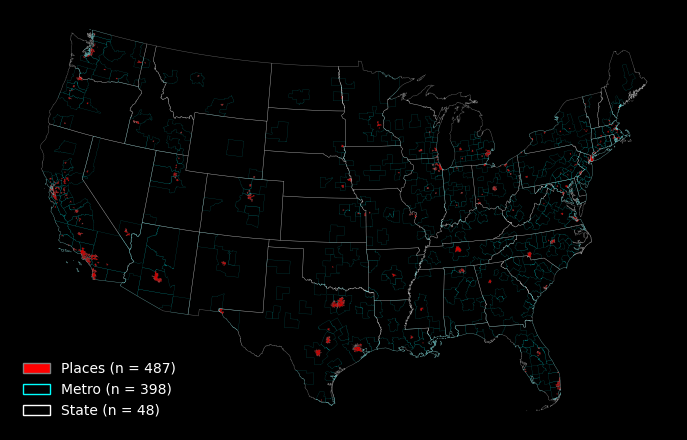

✅ Map saved to: d:\natcap\invest-mental-health\figures\places_within_metros_487_blk.png


In [156]:
f = f"places_within_metros_{n_places}_blk.png"
output_path = os.path.join(dir_figure, f)


# Create the plot
fig, ax = plt.subplots(figsize=(7, 4.5))

# Set black background
fig.patch.set_facecolor('black')   # Figure background
ax.set_facecolor('black')          # Axes background

# Plot layers
state_layer_mainland.boundary.plot(ax=ax, color='white', linewidth=0.3, alpha=0.4)
met_layer_mainland.boundary.plot(ax=ax, color='cyan', linewidth=0.15, alpha=0.4)
places_in_met_unique_mainland.plot(ax=ax, color='red', edgecolor='gray', linewidth=0.05, alpha=0.8)

# Legend with white text
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='gray', label=f'Places (n = {len(places_in_met_unique_mainland)})'),
    Patch(facecolor='none', edgecolor='cyan', label=f'Metro (n = {len(met_layer_mainland)})'),
    Patch(facecolor='none', edgecolor='white', label=f'State (n = {len(state_layer_mainland)})')
]
# legend = ax.legend(handles=legend_elements, loc='lower left', facecolor='black', edgecolor='white')
legend = ax.legend(handles=legend_elements, loc='lower left', frameon=False)
for text in legend.get_texts():
    text.set_color("white")  # Set legend text color to white

# Title
# ax.set_title("Places Within or Overlapping Metropolitan Areas", fontsize=14, color='white')
ax.axis("off")

# Save
plt.tight_layout()
plt.savefig(output_path, dpi=900, facecolor=fig.get_facecolor())  # Ensure black background is saved
plt.show()

print(f"✅ Map saved to: {output_path}")


### plot - dots

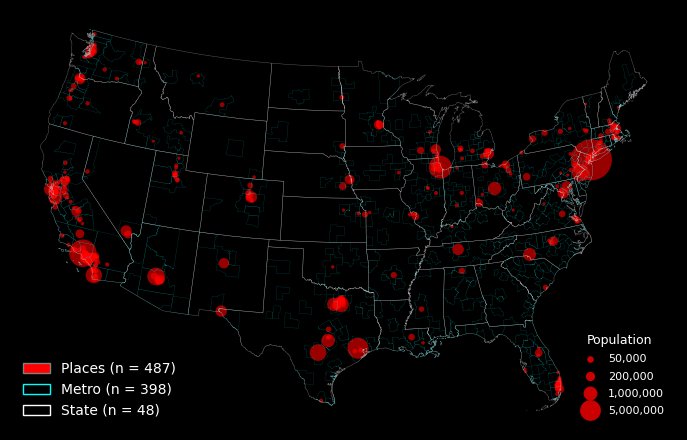

✅ Map saved to: d:\natcap\invest-mental-health\figures\places_within_metros_487_blk_pts.png


In [157]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import os

# Save path
f = f"places_within_metros_{n_places}_blk_pts.png"
output_path = os.path.join(dir_figure, f)

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4.5))

# Set black background
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plot state and metro boundaries
state_layer_mainland.boundary.plot(ax=ax, color='white', linewidth=0.3, alpha=0.4)
met_layer_mainland.boundary.plot(ax=ax, color='cyan', linewidth=0.15, alpha=0.4)

# Plot place centroids as red dots scaled by population
place_centroids = places_in_met_unique_mainland.copy()
place_centroids['geometry'] = place_centroids.centroid
dot_sizes = place_centroids['POP2020_left'] / 10000  # adjust scaling if needed
place_centroids.plot(ax=ax, markersize=dot_sizes, color='red', alpha=0.6, linewidth=0)

# Main legend (colors and outlines)
legend_elements = [
    Patch(facecolor='red', edgecolor='gray', label=f'Places (n = {len(places_in_met_unique_mainland)})'),
    Patch(facecolor='none', edgecolor='cyan', label=f'Metro (n = {len(met_layer_mainland)})'),
    Patch(facecolor='none', edgecolor='white', label=f'State (n = {len(state_layer_mainland)})'),
]

# Create nested bubble legend
pop_sizes = [50000, 200000, 1000000, 5000000]  # Population thresholds for bubble sizes
# Calculate proportional sizes (match dot size scaling)
legend_sizes = [np.sqrt(p / 10000) for p in pop_sizes]  # sqrt for area scaling

# Create legend elements for bubbles
bubble_legend = [
    plt.scatter([], [], s=s*10,  # scale factor for visibility
                facecolors='red', 
                edgecolors='white',
                linewidth=0,
                alpha=0.8) 
    for s in legend_sizes
]

# Create and customize bubble legend
bubble_labels = [f'{p:,}' for p in pop_sizes]
size_legend = ax.legend(
    bubble_legend, bubble_labels,
    title='Population',
    labelspacing=.4,  # vertical spacing
    handletextpad=.3, # space between symbol/text
    borderpad=.5,      # padding around legend
    frameon=False,
    loc='lower right'
)

# Style text in bubble legend
plt.setp(size_legend.get_title(), color='white', size=9)
for text in size_legend.get_texts():
    text.set_color('white')
    text.set_size(8)

# Add main legend (overwrite bubble legend, then re-add)
ax.add_artist(size_legend)
legend = ax.legend(handles=legend_elements, loc='lower left', frameon=False)
legend.get_title().set_color("white")
for text in legend.get_texts():
    text.set_color("white")

# Remove axes
ax.axis("off")

# Save
plt.tight_layout()
plt.savefig(output_path, dpi=900, facecolor=fig.get_facecolor())
plt.show()

print(f"✅ Map saved to: {output_path}")

###  Overlap area calculation


In [158]:

# ======= Overlap area calculation =======

# Compute exact intersection geometries
intersection = gpd.overlay(
    places_in_met_unique, met_layer, 
    how='intersection', 
    keep_geom_type=False
)

# # Compute area of intersections
# intersection['overlap_area'] = intersection.geometry.area

# Reproject to a projected CRS (e.g., EPSG:5070 = NAD83 / Conus Albers, perfect for the U.S.)
projected_crs = "EPSG:5070"  # Or use EPSG:3857 for Web Mercator
intersection_proj = intersection.to_crs(projected_crs)

# Now compute area in km2
intersection_proj['overlap_km2'] = (intersection_proj.geometry.area / 1e6).round(2)

print(intersection_proj.columns)


Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID_left', 'GEOID_PLAC',
       'NAME_PLACE', 'NAMELSAD_left', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'SUMLEV', 'STATE', 'PLACE', 'POP2020_left', 'POP2021_left',
       'POP2022_left', 'POP2023_left', 'POP2024_left', 'POP_KM2_left',
       'CSAFP_1', 'CBSAFP_1', 'METDIVFP_1', 'AFFGEOID_right', 'GEOID_METR_1',
       'NAME_METRO_1', 'NAMELSAD_right', 'LSAD_x_1', 'MDIV_1', 'LSAD_y_1',
       'SBASE2020_1', 'POP2020_right', 'POP2021_right', 'POP2022_right',
       'POP2023_right', 'POP2024_right', 'GEOID_MDIV_1', 'POP_KM2_right',
       'count_1', 'level_1', 'CSAFP_2', 'CBSAFP_2', 'METDIVFP_2', 'AFFGEOID',
       'GEOID_METR_2', 'NAME_METRO_2', 'NAMELSAD', 'LSAD_x_2', 'MDIV_2',
       'LSAD_y_2', 'SBASE2020_2', 'POP2020', 'POP2021', 'POP2022', 'POP2023',
       'POP2024', 'GEOID_MDIV_2', 'POP_KM2', 'count_2', 'level_2',
       'STATE_ABBR', 'geometry', 'overlap_km2'],
      dtype='object')


In [159]:

# Group by GEOID and NAME_PLACE, summing overlap areas
metro_place = (
    intersection_proj.groupby(['GEOID_METR_1', 'GEOID_METR_2', 'NAME_METRO_1', 'GEOID_PLAC', 'NAME_PLACE'])['overlap_km2']
    .sum()
    .reset_index()
)

print("Sample of overlap areas:")
print(metro_place.head())

print(places_in_met_unique.shape)
print(metro_place.shape)

print(intersection_proj.geometry.geom_type.unique())


Sample of overlap areas:
  GEOID_METR_1 GEOID_METR_2        NAME_METRO_1 GEOID_PLAC NAME_PLACE  \
0        10420        10420           Akron, OH    3901000      Akron   
1        10540        10540  Albany-Lebanon, OR    4101000     Albany   
2        10540        10540  Albany-Lebanon, OR    4115800  Corvallis   
3        10540        18700  Albany-Lebanon, OR    4101000     Albany   
4        10540        18700  Albany-Lebanon, OR    4115800  Corvallis   

   overlap_km2  
0       161.35  
1        36.07  
2         0.00  
3        10.25  
4        37.45  
(487, 42)
(581, 6)
['Polygon' 'LineString' 'GeometryCollection' 'MultiPolygon'
 'MultiLineString']
